Copyright 2019 Anthony Ng.

&emsp;

Licensed under the Apache License, Version 2.0 (the "License");

you may not use this file except in compliance with the License.

You may obtain a copy of the License at


&emsp;https://www.apache.org/licenses/LICENSE-2.0


Unless required by applicable law or agreed to in writing, software

distributed under the License is distributed on an "AS IS" BASIS,

WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and

limitations under the License.

# Transfer Learning


[TensorFlow Hub](http://tensorflow.org/hub) - online repository of pre-trained TensorFlow models.

Transfer learning - take an existing trained model, and apply it to problem it was not necessarily trained for. The basic idea involves leaving most of the model unchanged except for the final layer being trained to the specific problems.

All the models can be accessed via [TensorFlow Module Hub](https://tfhub.dev/).

## Dogs and Cats

In [1]:
import numpy as np

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Scenario 1: Using TenFlow Hub MobileNet for Prediction

MobileNet v2.

For other [pre-trained models](https://tfhub.dev/s?q=tf2&module-type=image-classification)

MobileNet expects images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Sourcing Data

[Kaggle Cats and Dogs Dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats)

We are using a small extract of the original dataset.

In [4]:
url = "https://github.com/anthonyng2/ml_python_2019/raw/master/dogs_and_cats.zip"
zip_dir = tf.keras.utils.get_file('dogs_and_cats.zip', origin=url, extract=True)

24502272/24497018 [==============================] - 0s 0us/step


In [5]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/dogs_and_cats
/root/.keras/datasets/dogs_and_cats/validation
/root/.keras/datasets/dogs_and_cats/validation/dogs
/root/.keras/datasets/dogs_and_cats/validation/cats
/root/.keras/datasets/dogs_and_cats/train
/root/.keras/datasets/dogs_and_cats/train/dogs
/root/.keras/datasets/dogs_and_cats/train/cats


In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'dogs_and_cats')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 400
total training dog images: 400
total validation cat images: 150
total validation dog images: 150
--
Total training images: 800
Total validation images: 300


## Let's apply

In [0]:
import PIL.Image as Image

In [26]:
!ls /root/.keras/datasets/dogs_and_cats/train/cats/ | head -10

cat.0.jpg
cat.100.jpg
cat.101.jpg
cat.102.jpg
cat.103.jpg
cat.104.jpg
cat.105.jpg
cat.106.jpg
cat.107.jpg
cat.108.jpg


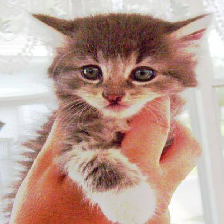

In [27]:
cat = Image.open("/root/.keras/datasets/dogs_and_cats/train/cats/cat.100.jpg").resize((IMAGE_RES, IMAGE_RES))
cat

In [28]:
cat = np.array(cat)/255.0
cat.shape

(224, 224, 3)

In [29]:
result = model.predict(cat[np.newaxis, ...])
result.shape

(1, 1001)

In [30]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

282

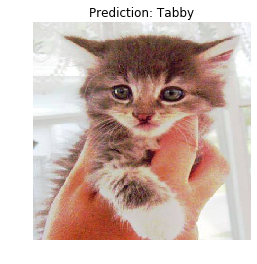

In [31]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(cat)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [32]:
!ls /root/.keras/datasets/dogs_and_cats/train/dogs/ | head -10

dog.0.jpg
dog.100.jpg
dog.101.jpg
dog.102.jpg
dog.103.jpg
dog.104.jpg
dog.105.jpg
dog.106.jpg
dog.107.jpg
dog.108.jpg


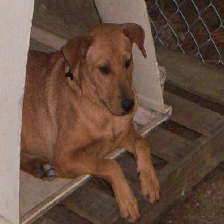

In [34]:
dog = Image.open("/root/.keras/datasets/dogs_and_cats/train/dogs/dog.100.jpg").resize((IMAGE_RES, IMAGE_RES))
dog

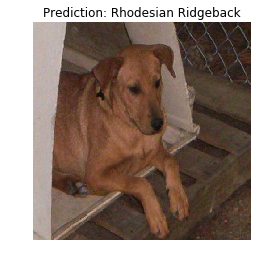

In [35]:
dog = np.array(dog)/255.0
result = model.predict(dog[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(dog)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())



---

More work...

# Scenario 2: Transfer Learning

In [37]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [39]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['beagle', 'red wolf', 'Egyptian cat', 'Egyptian cat', 'kelpie',
       'Tibetan mastiff', 'Bouvier des Flandres', 'prison', 'wallaby',
       'Norwich terrier', 'malinois', 'Egyptian cat', 'tabby',
       'Labrador retriever', 'Persian cat', 'lynx', 'whippet', 'tabby',
       'Brittany spaniel', 'Staffordshire bullterrier', 'Great Dane',
       'Walker hound', 'Egyptian cat', 'Great Dane',
       'American Staffordshire terrier', 'mouse', 'Border collie',
       'tiger cat', 'Egyptian cat', 'tabby', 'Siamese cat', 'Great Dane'],
      dtype='<U30')

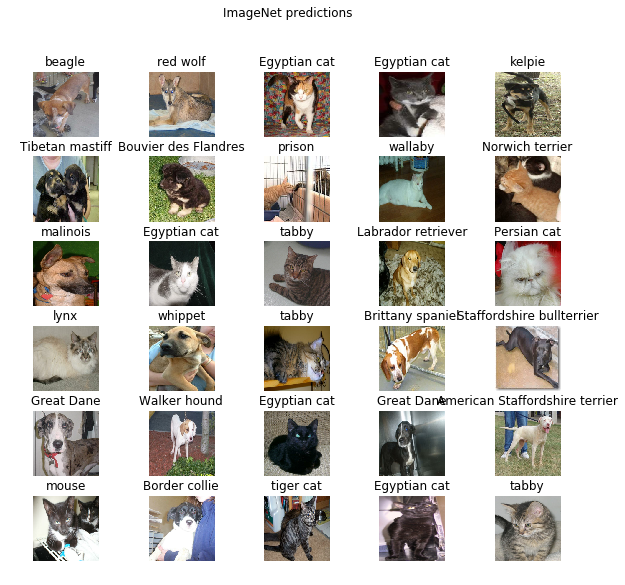

In [43]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES,3))

In [41]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

In [45]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 70s 120ms/step - loss: 0.0614 - accuracy: 0.9774 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 64s 109ms/step - loss: 0.0298 - accuracy: 0.9901 - val_loss: 0.0309 - val_accuracy: 0.9890
Epoch 3/6
582/582 [==============================] - 62s 107ms/step - loss: 0.0244 - accuracy: 0.9917 - val_loss: 0.0331 - val_accuracy: 0.9879
Epoch 4/6
582/582 [==============================] - 63s 108ms/step - loss: 0.0215 - accuracy: 0.9923 - val_loss: 0.0304 - val_accuracy: 0.9892
Epoch 5/6
582/582 [==============================] - 63s 108ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0361 - val_accuracy: 0.9869
Epoch 6/6
582/582 [==============================] - 63s 109ms/step - loss: 0.0163 - accuracy: 0.9941 - val_loss: 0.0332 - val_accuracy: 0.9884


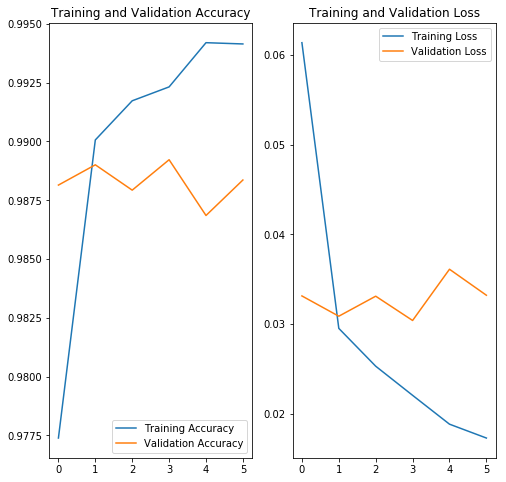

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model

In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [0]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 800 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 300 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen) 

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

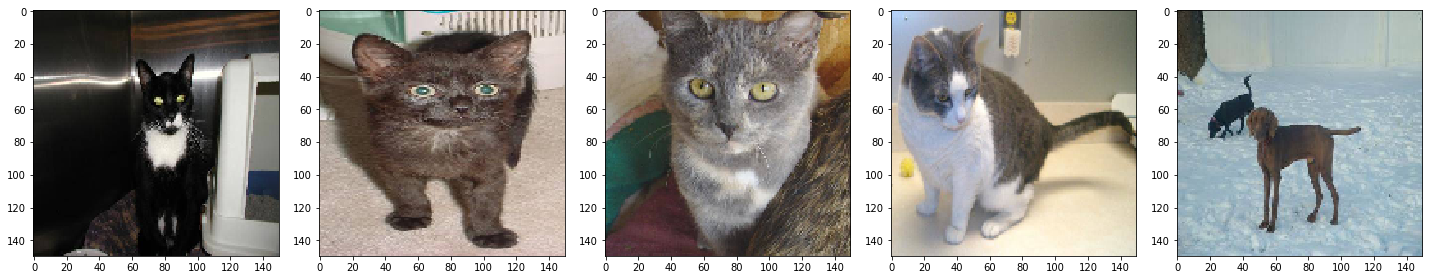

In [0]:
plotImages(sample_training_images[:5])  # Plot images 0-4

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [0]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
8/8 [==============================] - 7s 870ms/step - loss: 0.7823 - accuracy: 0.5150 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 4s 500ms/step - loss: 0.6939 - accuracy: 0.5088 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 4s 485ms/step - loss: 0.6910 - accuracy: 0.5163 - val_loss: 0.6877 - val_accuracy: 0.6033
Epoch 4/100
8/8 [==============================] - 4s 507ms/step - loss: 0.6833 - accuracy: 0.5600 - val_loss: 0.6738 - val_accuracy: 0.6033
Epoch 5/100
8/8 [==============================] - 4s 495ms/step - loss: 0.6685 - accuracy: 0.5800 - val_loss: 0.6543 - val_accuracy: 0.6300
Epoch 6/100
8/8 [==============================] - 4s 483ms/step - loss: 0.6385 - accuracy: 0.6363 - val_loss: 0.6741 - val_accuracy: 0.5967
Epoch 7/100
8/8 [==============================] - 4s 479ms/step - loss: 0.6221 - accuracy: 0.6612 - val_loss: 0.6386 - val_accuracy: 0.6800
Epoch 8/100
8

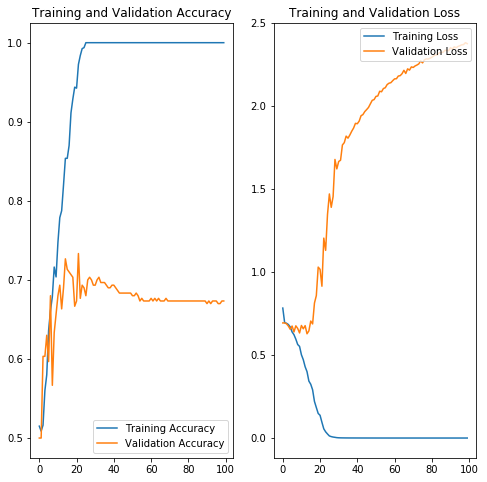

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

***

# CNN with Data Augmentation

In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

## Data Augmentation

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## flipping

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 800 images belonging to 2 classes.


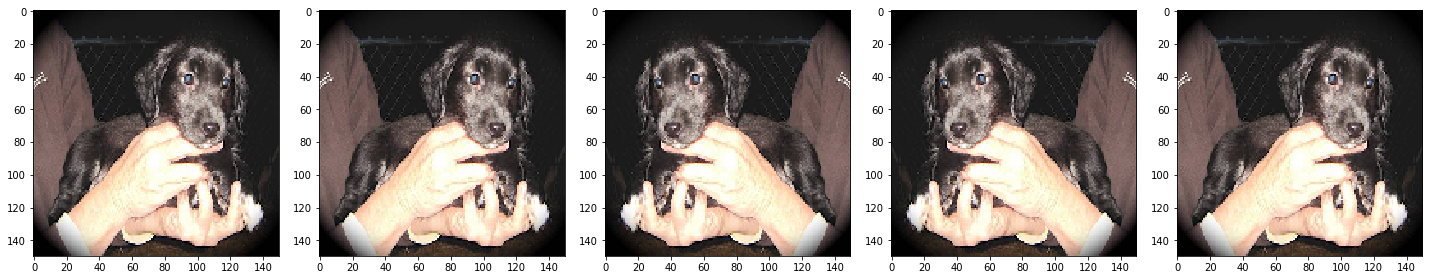

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 800 images belonging to 2 classes.


## rotate

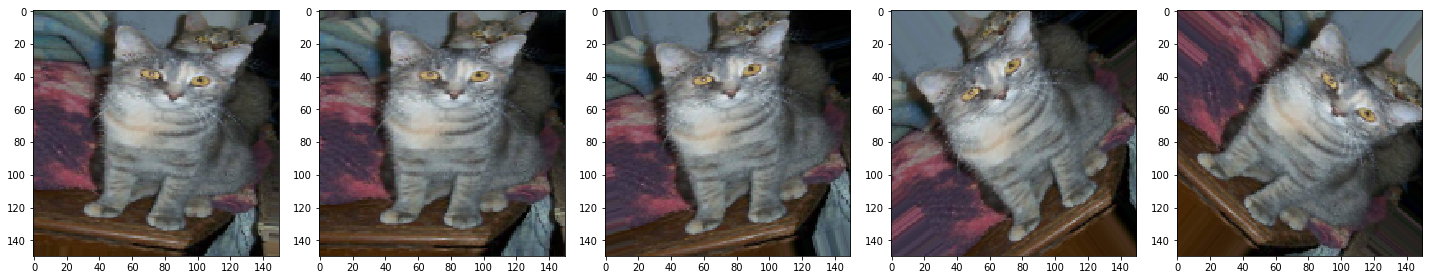

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## zoom

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 800 images belonging to 2 classes.


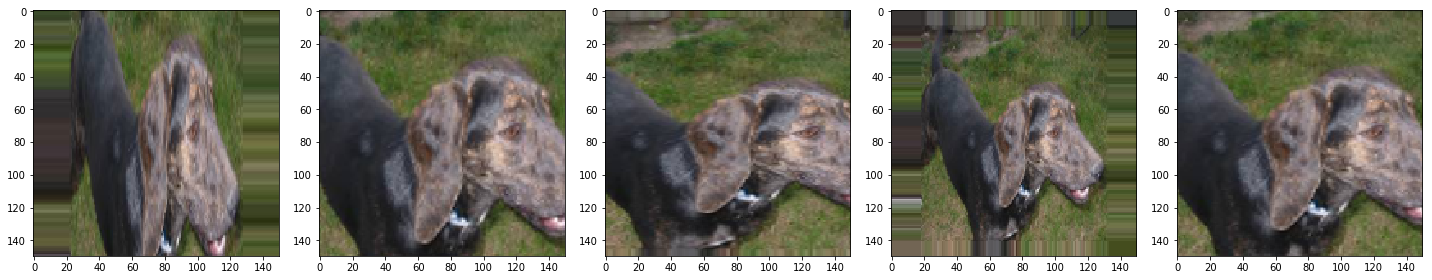

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## combining all

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 800 images belonging to 2 classes.


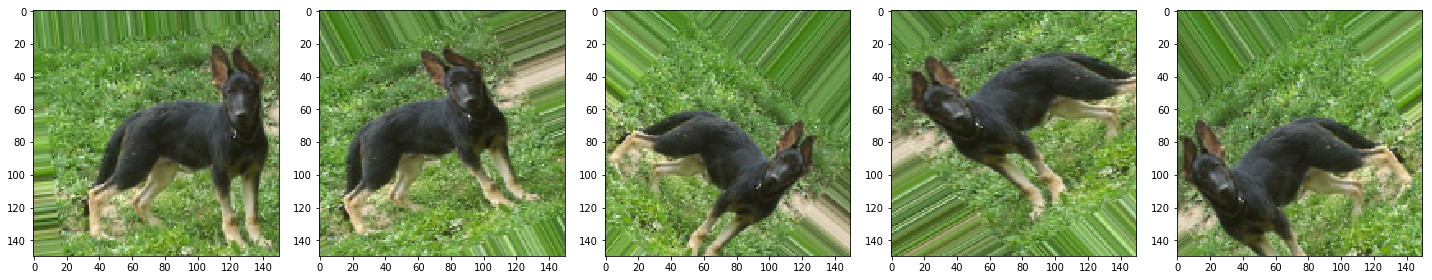

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## validation data generator

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 300 images belonging to 2 classes.


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [0]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 0.8308 - accuracy: 0.4925 - val_loss: 0.6936 - val_accuracy: 0.4900
Epoch 2/100
8/8 [==============================] - 8s 996ms/step - loss: 0.6961 - accuracy: 0.4638 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 8s 994ms/step - loss: 0.6937 - accuracy: 0.4850 - val_loss: 0.6930 - val_accuracy: 0.4967
Epoch 4/100
8/8 [==============================] - 8s 976ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6926 - val_accuracy: 0.5367
Epoch 5/100
8/8 [==============================] - 8s 994ms/step - loss: 0.6925 - accuracy: 0.5175 - val_loss: 0.6919 - val_accuracy: 0.5033
Epoch 6/100
8/8 [==============================] - 8s 984ms/step - loss: 0.6926 - accuracy: 0.5013 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 7/100
8/8 [==============================] - 8s 991ms/step - loss: 0.6906 - accuracy: 0.5312 - val_loss: 0.6894 - val_accuracy: 0.5500
Epoch 8/100
8/8 

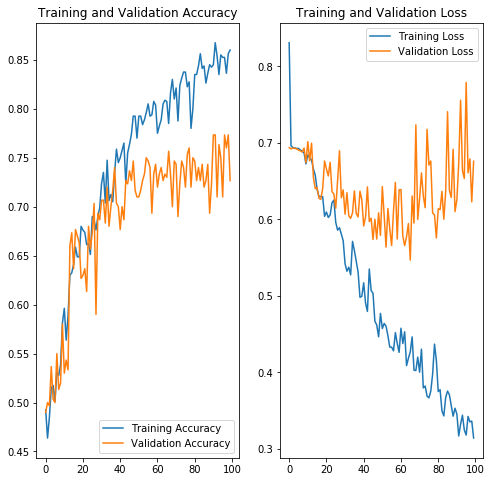

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***